In [1]:
# import modules
import torch
from torch import optim

import torch_geometric
from torch_geometric.loader import DataLoader
from ogb.graphproppred import PygGraphPropPredDataset

from module.set_seed import set_seed
from module.argument import get_parser
from module.model import GNNGraphPred
from module.train import train, aais_sgd_train, aais_adam_train, evaluation

import numpy as np
from copy import deepcopy

Load arguments

In [152]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

parser = get_parser()
try:
    args = parser.parse_args()
except:
    args = parser.parse_args([])

args.dataset = 'clintox'
args.num_workers = 0
args.train_type = 'aais'

if args.dataset == "tox21":
    num_task = 12
elif args.dataset == "hiv":
    num_task = 1
elif args.dataset == "bace":
    num_task = 1
elif args.dataset == "bbbp":
    num_task = 1
elif args.dataset == "toxcast":
    num_task = 617
elif args.dataset == "sider":
    num_task = 27
elif args.dataset == "clintox":
    num_task = 2    

print(args)

Namespace(num_runs=10, batch_size=32, epochs=100, lr=0.001, lr_scale=1, num_layer=5, emb_dim=300, dropout_ratio=0.5, graph_pooling='mean', JK='last', gnn_type='gcn', ratio=0.5, m=3, step_size=0.001, max_pert=0.01, burn=20, dataset='clintox', num_workers=0, virtual=False, residual=False, train_type='aais', optim_method='sgd')


usage: ipykernel_launcher.py [-h] [--num_runs NUM_RUNS]
                             [--batch_size BATCH_SIZE] [--epochs EPOCHS]
                             [--lr LR] [--lr_scale LR_SCALE]
                             [--num_layer NUM_LAYER] [--emb_dim EMB_DIM]
                             [--dropout_ratio DROPOUT_RATIO]
                             [--graph_pooling GRAPH_POOLING] [--JK JK]
                             [--gnn_type GNN_TYPE] [--ratio RATIO] [--m M]
                             [--step_size STEP_SIZE] [--max_pert MAX_PERT]
                             [--burn BURN] [--dataset DATASET]
                             [--num_workers NUM_WORKERS] [--virtual VIRTUAL]
                             [--residual RESIDUAL] [--train_type TRAIN_TYPE]
                             [--optim_method OPTIM_METHOD]
ipykernel_launcher.py: error: unrecognized arguments: --f=/Users/soyoungcho/Library/Jupyter/runtime/kernel-v2-1345Z06VG2RJL7KH.json


Data preparation

In [153]:
dataset = PygGraphPropPredDataset(name = f'ogbg-mol{args.dataset}', root = 'dataset')
split_idx = dataset.get_idx_split()

train_loader = DataLoader(dataset[split_idx['train']], batch_size = args.batch_size, shuffle = True, num_workers = args.num_workers)
val_loader = DataLoader(dataset[split_idx['valid']], batch_size = args.batch_size, shuffle = False, num_workers = args.num_workers)
test_loader = DataLoader(dataset[split_idx['test']], batch_size = args.batch_size, shuffle = False, num_workers = args.num_workers)

Downloaded 0.00 GB: 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]
Processing...


Extracting dataset/clintox.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1477/1477 [00:00<00:00, 148532.34it/s]


Converting graphs into PyG objects...


100%|██████████| 1477/1477 [00:00<00:00, 63154.22it/s]

Saving...



Done!


Training loop

In [155]:
criterion = torch.nn.BCEWithLogitsLoss(reduction = 'sum')

auc_vals, auc_tests = [], []
f1_vals, f1_tests = [], []

seed = 0
set_seed(seed)
torch_geometric.seed_everything(seed)
        
best_val_auc, final_test_auc = 0, 0
best_val_f1, final_test_f1 = 0, 0
        
model = GNNGraphPred(num_tasks = num_task, num_layer = args.num_layer, emb_dim = args.emb_dim, 
                    gnn_type = args.gnn_type,
                    graph_pooling = args.graph_pooling, drop_ratio = args.dropout_ratio, JK = args.JK, 
                    virtual_node = args.virtual, residual = args.residual)
model = model.to(device)

        
if args.optim_method == 'sgd':
    optimizer = optim.SGD(model.parameters(), lr = args.lr)
elif args.optim_method == 'adam':
    iteration = 0
    first_moment = 0.
    second_moment = 0.
    optimizer = optim.Adam(model.parameters(), lr = args.lr)


for epoch in range(1, args.epochs + 1):
    if (args.train_type == 'aais') & (args.optim_method == 'sgd'):
        if epoch <= args.burn:
            train(model, device, train_loader, criterion, optimizer)
        else:
            aais_sgd_train(model, device, train_loader, criterion, optimizer, args)
    elif (args.train_type == 'aais') & (args.optim_method == 'adam'):
        if epoch <= args.burn:
            train(model, device, train_loader, criterion, optimizer)
        else:
            iteration, first_moment, second_moment = aais_adam_train(model, device, train_loader, criterion, optimizer, args, iteration, first_moment, second_moment)
    
    train_loss, train_auc, train_f1 = evaluation(model, device, train_loader, criterion, args)
    val_loss, val_auc, val_f1 = evaluation(model, device, val_loader, criterion, args)
    test_loss, test_auc, test_f1 = evaluation(model, device, test_loader, criterion, args)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
        best_val_f1 = val_f1
        final_test_f1 = test_f1
        
        best_epoch = epoch
        model_params = deepcopy(model.state_dict())

    if epoch % 10 == 0:
        print(f'=== epoch {epoch}')
        print(f'train loss: {train_loss:.4f}, train auc: {train_auc*100:.2f}')
        print(f'val loss: {val_loss:.4f}, val auc: {val_auc*100:.2f}')
        print(f'test loss: {test_loss:.4f}, test auc: {test_auc*100:.2f}')



Random seed set as 0
=== epoch 10
train loss: 0.7632, train auc: 48.79
val loss: 0.7720, val auc: 37.10
test loss: 0.7685, test auc: 43.75
=== epoch 20
train loss: 0.7584, train auc: 50.63
val loss: 0.7676, val auc: 38.02
test loss: 0.7640, test auc: 45.38
=== epoch 30
train loss: 0.5871, train auc: 73.59
val loss: 0.5762, val auc: 66.51
test loss: 0.5911, test auc: 70.76
=== epoch 40
train loss: 0.5786, train auc: 84.12
val loss: 0.5710, val auc: 75.16
test loss: 0.5852, test auc: 75.32
=== epoch 50
train loss: 0.5790, train auc: 87.23
val loss: 0.5724, val auc: 79.99
test loss: 0.5913, test auc: 77.83
=== epoch 60
train loss: 0.5591, train auc: 90.03
val loss: 0.5494, val auc: 88.81
test loss: 0.5697, test auc: 77.91
=== epoch 70
train loss: 0.5655, train auc: 91.72
val loss: 0.5565, val auc: 94.21
test loss: 0.5867, test auc: 82.12
=== epoch 80
train loss: 0.5602, train auc: 93.50
val loss: 0.5504, val auc: 97.74
test loss: 0.5825, test auc: 82.95
=== epoch 90
train loss: 0.5462, tr

Calculating the One-Step Influence Function

In [156]:
model.load_state_dict(model_params)
model.eval()

GNNGraphPred(
  (gnn): GNN(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 300)
        (1): Embedding(5, 300)
        (2-3): 2 x Embedding(12, 300)
        (4): Embedding(10, 300)
        (5-6): 2 x Embedding(6, 300)
        (7-8): 2 x Embedding(2, 300)
      )
    )
    (gnns): ModuleList(
      (0-4): 5 x GCNConv()
    )
    (batch_norms): ModuleList(
      (0-4): 5 x BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_linear): Linear(in_features=300, out_features=2, bias=True)
)

In [89]:
def flat_grad(grad_list):
    gradient = torch.cat([x.view(-1) for x in grad_list])
    return gradient
    

def sample_in_batch(batch, i):
    one_sample = batch[i]
    
    x = one_sample.x
    edge_attr = one_sample.edge_attr
    edge_index = one_sample.edge_index
    y = one_sample.y
    b = torch.zeros(one_sample.num_nodes).to(torch.int64).to(x.device)
    
    return (x, edge_attr, edge_index, b, y)


def compute_lin_sample_grad(model, embedding, target, criterion):
    model.eval()
    
    embedding = embedding.unsqueeze(0)
    pred = model(embedding).to(torch.float32)
    
    y = target.view(pred.shape).to(torch.float32)
    is_labeled = y==y
    loss = criterion(pred[is_labeled], y[is_labeled])
    
    return torch.autograd.grad(loss, model.parameters())


def sgd_lin_if(model, batch, criterion, args):
    model.eval()
    
    eta = args.lr
    
    embeddings = model.pool(model.gnn(batch), batch.batch)
    targets = batch.y
    
    sample_grads = torch.stack([flat_grad(compute_lin_sample_grad(model.graph_pred_linear, embeddings[i], targets[i], criterion)) for i in range(len(embeddings))])
    
    sample_influence = []
    for i in range(sample_grads.size(0)):
        if_tmp = torch.abs(eta * sample_grads[i].dot(sample_grads[i]))
        sample_influence.append(if_tmp)
    sample_influence = torch.stack(sample_influence)
    
    return sample_influence


In [157]:
for _, batch in enumerate(train_loader):
    break

sgd_lin_if(model, batch, criterion, args)

tensor([2.7682e-03, 1.7172e-02, 2.2566e-03, 6.1686e-03, 6.3925e-03, 1.5151e-02,
        1.2705e-02, 8.8224e-01, 2.8668e-04, 9.5102e-03, 3.8597e-02, 2.6323e-02,
        5.1619e-03, 1.3984e-01, 5.1100e-01, 1.7046e-02, 2.2029e-02, 4.2446e-03,
        7.0715e-03, 5.1215e-03, 7.9299e-01, 5.3564e-03, 3.8429e-03, 1.6845e-02,
        1.8598e-02, 1.5823e-02, 4.1902e-01, 1.3213e-03, 9.3488e-01, 2.3674e-03,
        7.2115e-01, 1.7574e-02])

In [165]:
train_y = []
test_y = []
train_embedding = []
test_embedding = []
train_influence = []
test_influence = []

for _, batch in enumerate(train_loader):
    train_y.append(batch.y[:, 1])
    train_embedding.append(model.pool(model.gnn(batch), batch.batch))
    train_influence.append(sgd_lin_if(model, batch, criterion, args))

for _, batch in enumerate(test_loader):
    test_y.append(batch.y[:, 1])
    test_embedding.append(model.pool(model.gnn(batch), batch.batch))
    test_influence.append(sgd_lin_if(model, batch, criterion, args))

In [166]:
train_y = torch.cat(train_y).view(-1).numpy()
train_embedding = torch.cat(train_embedding).detach().numpy()
train_influence = torch.cat(train_influence)

test_y = torch.cat(test_y).view(-1).numpy()
test_embedding = torch.cat(test_embedding).detach().numpy()
test_influence = torch.cat(test_influence)

Plotting the Top-k Influential data

/var/folders/4d/5b3mtqbs4nnf34wnrtg1cgcr0000gn/T/ipykernel_23853/2802149787.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  _, topk_idxs = torch.topk(torch.tensor(train_influence), train_top_k)


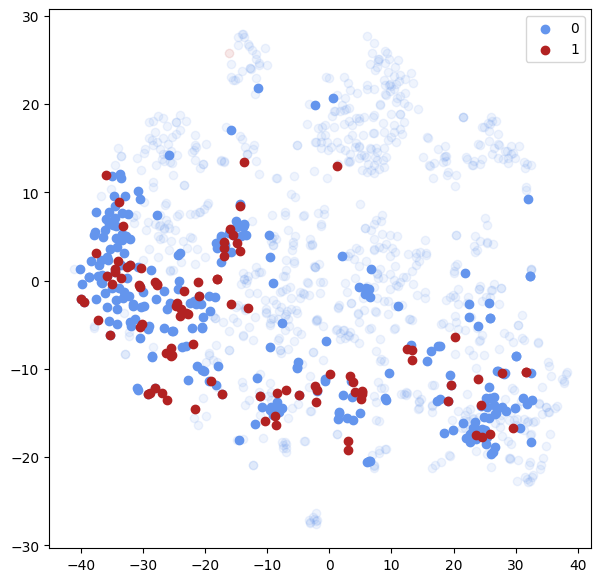

In [170]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components = 2, random_state = 0, perplexity = 50)
train_tsne = tsne.fit_transform(train_embedding)

train_top_k = int(len(train_y) * 0.3)
_, topk_idxs = torch.topk(torch.tensor(train_influence), train_top_k)
low_idxs = np.array([i for i in range(len(train_y)) if i not in topk_idxs])

cdict = {0: 'cornflowerblue', 1: 'firebrick'}

fig, ax = plt.subplots(figsize = (7, 7))

for g in np.unique(train_y):
    idx = np.where(train_y[low_idxs] == g)[0]
    ax.scatter(train_tsne[low_idxs][idx][:, 0], train_tsne[low_idxs][idx][:, 1], label = '_nolgend_', c = cdict[g], alpha = 0.1)

for g in np.unique(train_y):
    idx = np.where(train_y[topk_idxs] == g)[0]
    ax.scatter(train_tsne[topk_idxs][idx][:, 0], train_tsne[topk_idxs][idx][:, 1], c = cdict[g], label = g)

plt.legend()
plt.show()
plt.close()


- While the dimensions are not neatly separated for each label, data points with high influence primarily appear in regions where major and minor labels overlap.